In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, ParameterGrid


param_grid = {
    "n_components": [1, 2],
    "covariance_type": ["tied"],
}


def get_n_components(data):
    
    res = []
    estimators = []
    for param in ParameterGrid(param_grid):
        gm = GaussianMixture(**param).fit(data)
        param['score'] = gm.bic(data)
        res.append(param)
        estimators.append(gm)
    
    df = pd.DataFrame.from_records(res)
    best_params = df[df['score']==df['score'].min()].to_dict(orient='records')[0]
    return best_params['n_components'], min(df['score'])-max(df['score'])


def run_experiment(params):
    sep, sd, sample_size, rep = params
    p1 = np.random.normal(0, sd, size=sample_size//2)
    p2 = np.random.normal(sep, sd, size=sample_size//2)
    data = np.concatenate((p1, p2))[:, np.newaxis]
    n_components, score_diff = get_n_components(data)
    
    return *params, n_components, score_diff


seps = [50]
stdevs = np.linspace(2.5, 50, 50)
sample_sizes = np.linspace(5, 250, 50).astype(int)
repeats = np.arange(100)

res = []

params = list(itertools.product(seps, stdevs, sample_sizes, repeats))
total = len(params)
# from multiprocessing import Pool
# with Pool(1) as p:
#     res = list(tqdm.tqdm(p.imap(run_experiment, params), total=len(params)))

res = list(tqdm.tqdm(map(run_experiment, params), total=len(params)))
# for sep, stdev, s_size in tqdm(, total=total):
#     print(sep, stdev, s_size)
#     n_components, score_diff = run_experiment(*param)
#     res.append([sep, stdev, s_size, n_components, score_diff])


100%|████████████████████████████████████████████████████████████████████████| 250000/250000 [14:36<00:00, 285.10it/s]


In [3]:
df = pd.DataFrame(res, columns=['seperation', 'stdev', 'sample_size', 'rep', 'bic_n_components', 'bic_score_diff'])


In [5]:
df.to_csv('./hist_experiments.csv')

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./hist_experiments.csv')
df = df[df['sample_size']>5]
print(df.shape)

(245000, 7)


In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, ParameterGrid


param_grid = {
    "n_components": [1, 2],
    "covariance_type": ["tied"],
}


def get_n_components(data):
    
    res = []
    estimators = []
    for param in ParameterGrid(param_grid):
        gm = GaussianMixture(**param).fit(data)
        param['score'] = gm.bic(data)
        res.append(param)
        estimators.append(gm)
    
    df = pd.DataFrame.from_records(res)
    best_params = df[df['score']==df['score'].min()].to_dict(orient='records')[0]
    return best_params['n_components'], min(df['score'])-max(df['score'])


def run_experiment(params):
    sep, sd, sample_size, rep = params
    p1 = np.random.normal(0, sd, size=sample_size//2)
    p2 = np.random.normal(sep, sd, size=sample_size//2)
    data = np.concatenate((p1, p2))[:, np.newaxis]
    n_components, score_diff = get_n_components(data)
    
    return *params, n_components, score_diff




In [132]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Define the Bayesian probability classification function
def bayesian_probability_classification(Z_i, mu_x, mu_y, sigma_x, sigma_y, n, m):
    """
    Calculate the probability of correctly classifying a point using Bayesian approach.
    
    Parameters:
    - Z_i: The data point to classify.
    - mu_x: Mean of the X distribution.
    - mu_y: Mean of the Y distribution.
    - sigma_x: Standard deviation of the X distribution.
    - sigma_y: Standard deviation of the Y distribution.
    - n: Sample size of X.
    - m: Sample size of Y.
    
    Returns:
    - P(X|Z_i): Posterior probability of class X given Z_i.
    - P(Y|Z_i): Posterior probability of class Y given Z_i.
    """
    # Likelihoods
    P_Zi_given_X = norm.pdf(Z_i, mu_x, sigma_x)
    P_Zi_given_Y = norm.pdf(Z_i, mu_y, sigma_y)
    
    # Priors
    P_X = n / (n + m)
    P_Y = m / (n + m)
    
    # Total probability
    P_Zi = P_Zi_given_X * P_X + P_Zi_given_Y * P_Y
    
    # Posterior probabilities
    P_X_given_Zi = (P_Zi_given_X * P_X) / P_Zi
    P_Y_given_Zi = (P_Zi_given_Y * P_Y) / P_Zi
    
    return P_X_given_Zi, P_Y_given_Zi

# Define the function to calculate the overall probability of correct classification
def probability_correct_classification(mu_x, mu_y, sigma_x, sigma_y, n, m):
    """
    Calculate the overall probability of correctly classifying points using the Bayesian approach.
    
    Parameters:
    - mu_x: Mean of the X distribution.
    - mu_y: Mean of the Y distribution.
    - sigma_x: Standard deviation of the X distribution.
    - sigma_y: Standard deviation of the Y distribution.
    - n: Sample size of X.
    - m: Sample size of Y.
    
    Returns:
    - prob: Overall probability of correctly classifying points.
    """
    # Generate a range of Z_i values
    Z_values = np.linspace(min(mu_x, mu_y) - 5*max(sigma_x, sigma_y), max(mu_x, mu_y) + 5*max(sigma_x, sigma_y), 1000)
    
    # Calculate the probability of correct classification
    total_prob = 0
    for Z_i in Z_values:
        P_X_given_Zi, P_Y_given_Zi = bayesian_probability_classification(Z_i, mu_x, mu_y, sigma_x, sigma_y, n, m)
        density = norm.pdf(Z_i, mu_x, sigma_x) * (n / (n + m)) + norm.pdf(Z_i, mu_y, sigma_y) * (m / (n + m))
        total_prob += max(P_X_given_Zi, P_Y_given_Zi) * density * (Z_values[1] - Z_values[0])
    
    return total_prob



In [193]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import tqdm

from sklearn.mixture import GaussianMixture

def get_best_gmm(data):
    data = data[:, None]
    best_bic = np.inf
    best_gmm = None
    for n in [1, 2]:
        gmm = GaussianMixture(n_components=n).fit(data)
        bic = gmm.bic(data)
        if bic < best_bic:
            best_gmm = gmm
            best_bic = bic
            
    return best_gmm.n_components

def run_experiment(mu_x, mu_y, sigma_x, sigma_y, n, m, repeats):
    res = []
    for _ in range(repeats):
        d1 = np.random.normal(mux, sigma_x, size=n)
        d2 = np.random.normal(muy, sigma_y, size=m)
        data = np.concatenate((d1, d2))
        res.append(int(get_best_gmm(data)==2))
    return np.mean(res)


def _andrewD(n, m, mux, muy, stdev):
    combined_se = np.sqrt(((stdev**2) / m) + ((stdev**2) / m))
    d_prime = abs(mux-muy) / combined_se
    # d_prime *= (np.sqrt(2) / (m+m))
    return d_prime


# Example usage for demonstration
mu_x = 0
mu_y = 50
sigma_x = 40
sigma_y = sigma_x
n = 100
m = 100




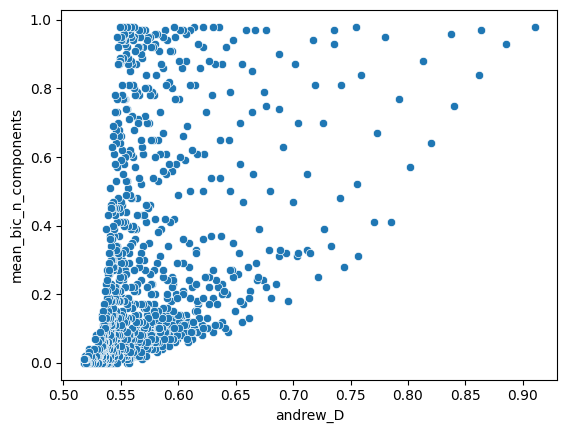

6       0.910588
7       0.885712
8       0.862192
9       0.840391
10      0.820398
          ...   
2445    0.519334
2446    0.518936
2447    0.518554
2448    0.518188
2449    0.517835
Name: andrew_D, Length: 1823, dtype: float64


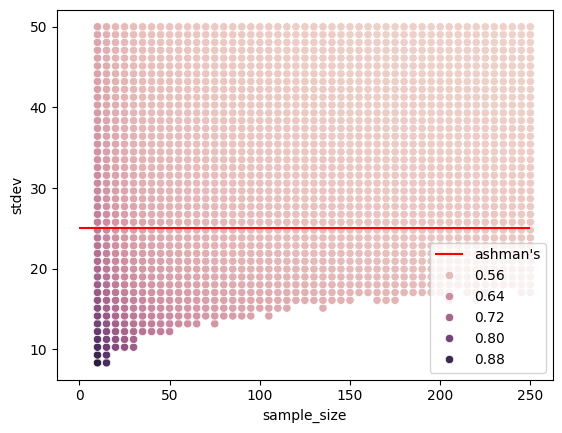

In [208]:
from scipy.stats import norm
from tqdm import tqdm

def _andrewD(n, m, mux, muy, stdev):
    combined_se = np.sqrt(((stdev**2) / m) + ((stdev**2) / m))
    d_prime = abs(mux-muy) / combined_se
    d_prime *= (np.sqrt(2) / (m+m))
    return norm.cdf(d_prime)


def andrewD(row):
    m = row['sample_size', '']/2
    n = m
    mux = 0
    muy = 50
    stdev = row['stdev', '']
    return _andrewD(n, m, mux, muy, stdev)
    

def count_correct(xs):
    return sum([x==2 for x in xs]) / len(xs)

threshold = 0.99
df2 = df2[df2['sample_size'] > 100]
df2 = df.groupby(['sample_size', 'stdev'], as_index = False).agg([count_correct])
df2['mean_bic_n_components'] = df2['bic_n_components', 'count_correct']
df2['andrew_D'] = [andrewD(row) for row in df2.to_dict(orient="records")]

df2['threshold'] = df2['mean_bic_n_components'] < threshold
df2 = df2[df2['threshold']]

sns.scatterplot(data=df2, x='andrew_D', y='mean_bic_n_components')
plt.show()

print(df2['andrew_D'])
plt.hlines(25, 0, 250, label='ashman\'s', color='red')
sns.scatterplot(data=df2, x='sample_size', y='stdev', hue='andrew_D', legend=True)
L=plt.legend(loc = 'lower right')

# L.get_texts()[1].set_text('P(reconstruction)>0.95')
plt.show()

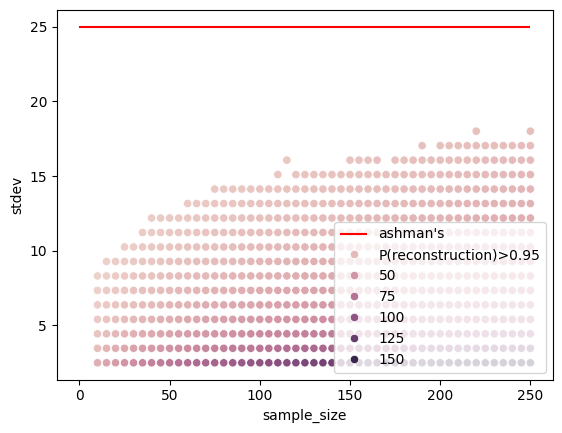

In [188]:
def count_correct(xs):
    return sum([x==2 for x in xs]) / len(xs)

threshold = 0.95
df2 = df.groupby(['sample_size', 'stdev'], as_index = False).agg([count_correct])
df2['mean_bic_n_components'] = df2['bic_n_components', 'count_correct']
df2['threshold'] = df2['mean_bic_n_components'] > threshold

df2 = df2[df2['threshold']]

plt.hlines(25, 0, 250, label='ashman\'s', color='red')
sns.scatterplot(data=df2, x='sample_size', y='stdev', hue='andrew_D', legend=True)
L=plt.legend(loc = 'lower right')

L.get_texts()[1].set_text('P(reconstruction)>0.95')
plt.show()


/tmp/ipykernel_121065/2189959451.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df3 = df3.groupby('stdev').min()


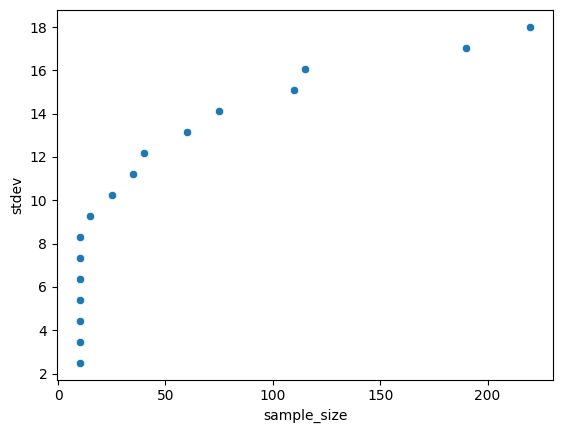

In [54]:
df3 = df2[['sample_size', 'stdev']]

df3 = df3.groupby('stdev').min()
sns.scatterplot(data=df3, x='sample_size', y='stdev')
plt.show()

dset = df3.reset_index().to_numpy().T


/tmp/ipykernel_121065/3298426363.py:2: RuntimeWarning: invalid value encountered in sqrt
  y = (lambda x: ((x-3)/(x-2.25))*np.sqrt((x-2)/x))(x)


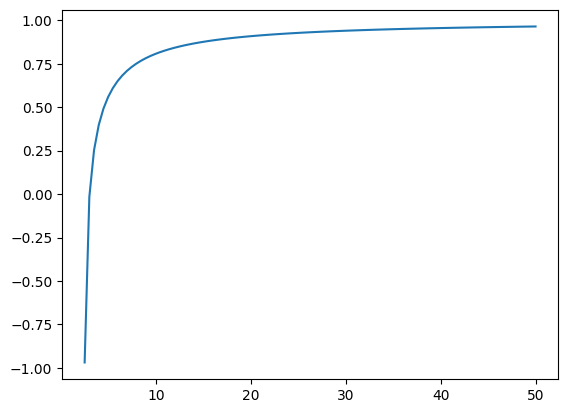

In [55]:
x = np.linspace(1, 50, 100)
y = (lambda x: ((x-3)/(x-2.25))*np.sqrt((x-2)/x))(x)

plt.plot(x,y)
     




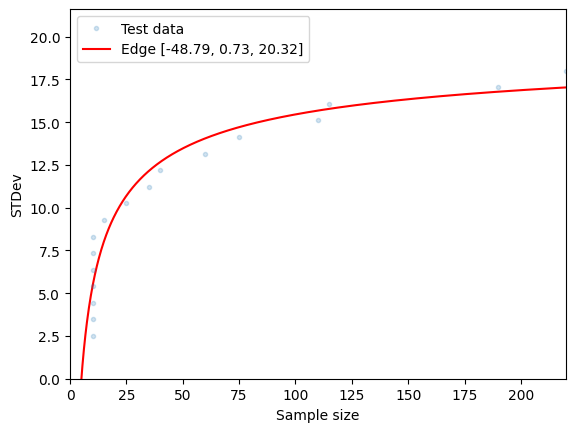

In [56]:
def model(x, a, b, c):
    return (a / np.sqrt(x + b) + c)

# def get_flipped(y_data, y_model):
#     flipped =  y_model - y_data
#     flipped[flipped < 0] = 0
#     return flipped

def resid(pars, x, y):
    """
    For every iteration, everything above the currently proposed
    curve is going to be mirrored down, so that the next iterations
    is going to progressively shift downwards.
    """
    y_model = model(x, *pars)
    resid = np.square(y - y_model)
    #print pars, resid.sum() # uncomment to check the iteration parameters
    return np.nan_to_num(resid)

# plotting the mock data
plt.plot(dset[1], dset[0], '.', alpha=0.2, label = 'Test data')

# mask bad data (we accidentaly generated some NaN values)

from scipy.optimize import leastsq
guesses =[-50, 10, 25]
fit_pars, flag = leastsq(func = resid, x0 = guesses,
                         args = (dset[1], dset[0]))


x_data = np.linspace(0, dset[1].max(), 1000)
# plot the fit:
y_fit = model(x_data, *fit_pars)
y_guess = model(x_data, *guesses)
fit_pars = [round(x, 2) for x in fit_pars]
plt.plot(x_data, y_fit, 'r-', zorder = 0.9, label = f'Edge {list(fit_pars)}')
# plt.plot(x_data, y_guess, 'g-', zorder = 0.9, label = 'Guess')
plt.ylim((0,dset[0].max()*1.2))
plt.xlim((0,dset[1].max()))

plt.xlabel('Sample size')
plt.ylabel('STDev')
plt.legend(loc = 'upper left')
plt.show()


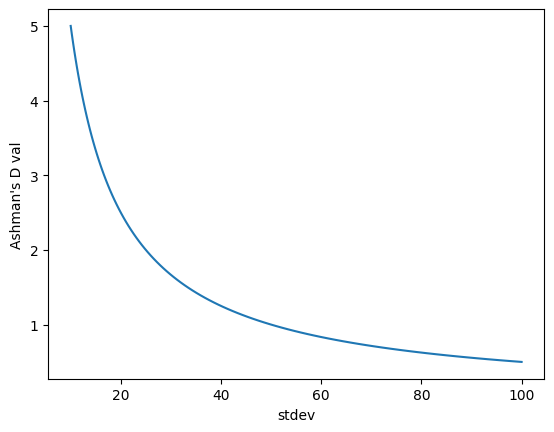

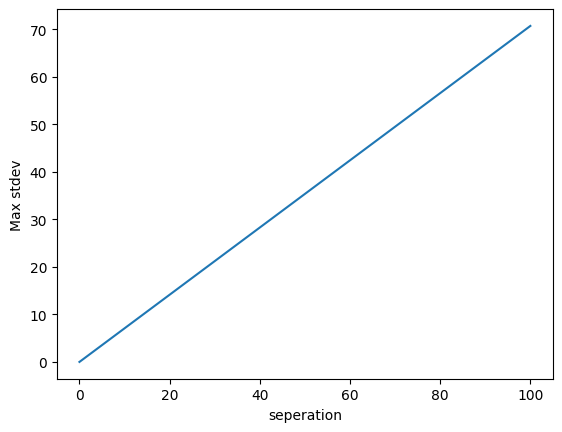

In [61]:
def ashmans_D(stdev, sep=50):
    return np.sqrt(2) * (sep/np.sqrt(2*(stdev**2)))

x = np.logspace(1, 2, 100)
y = ashmans_D(x)
plt.xlabel('stdev')
plt.ylabel('Ashman\'s D val')
plt.plot(x,y)
plt.show()

def ashmans_D_lim(seperation):
    return (np.sqrt(2)/2) * seperation

x = np.linspace(0, 100)
y = ashmans_D_lim(x)
plt.xlabel('seperation')
plt.ylabel('Max stdev')
plt.plot(x, y)

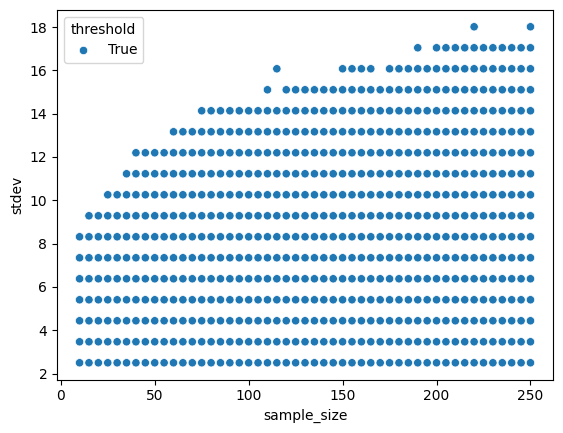

In [103]:

sns.scatterplot(data=df2, x='sample_size', y='stdev', hue='threshold')
plt.ylim
plt.show()

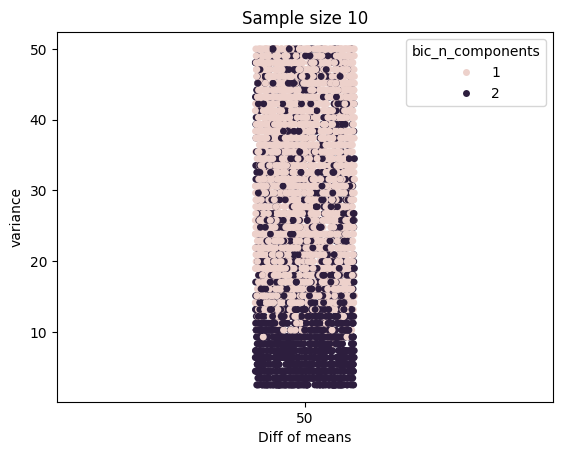

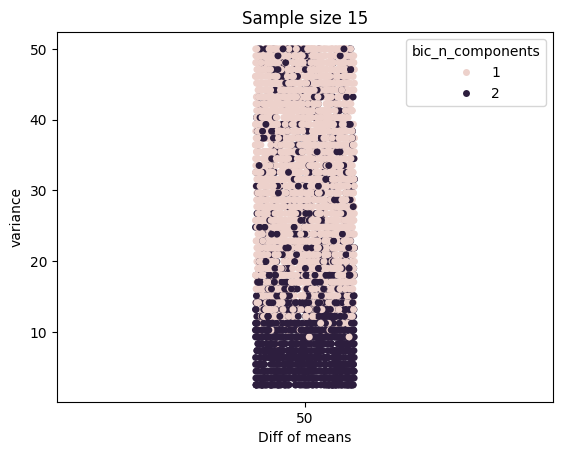

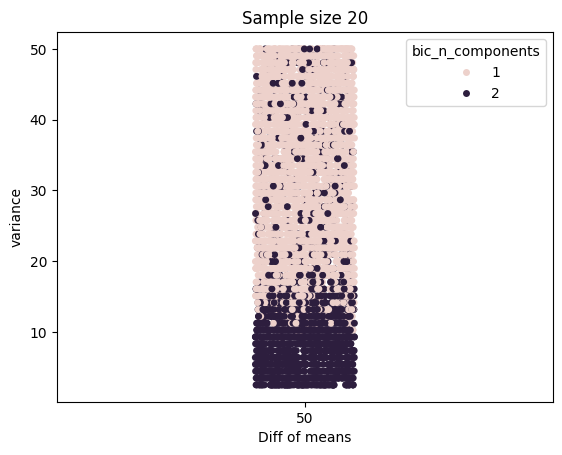

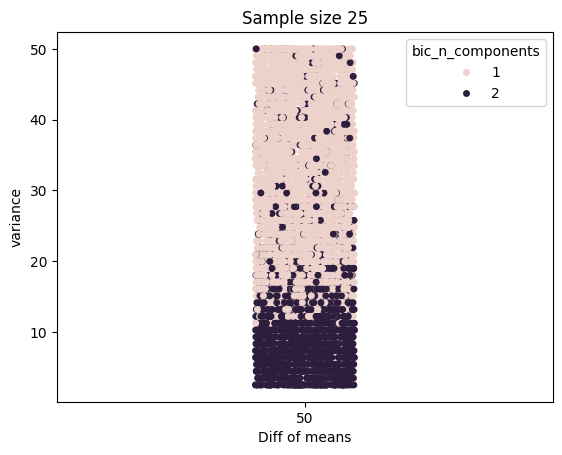

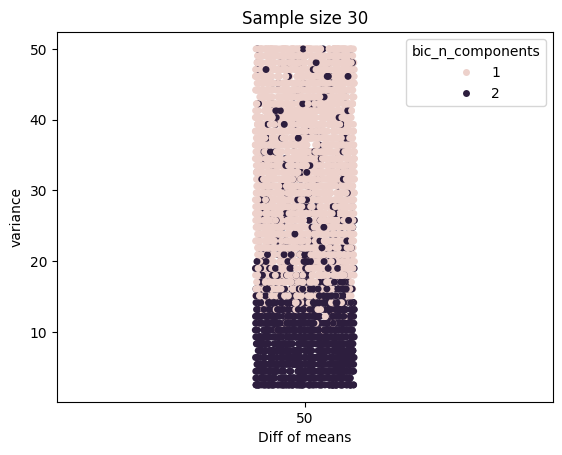

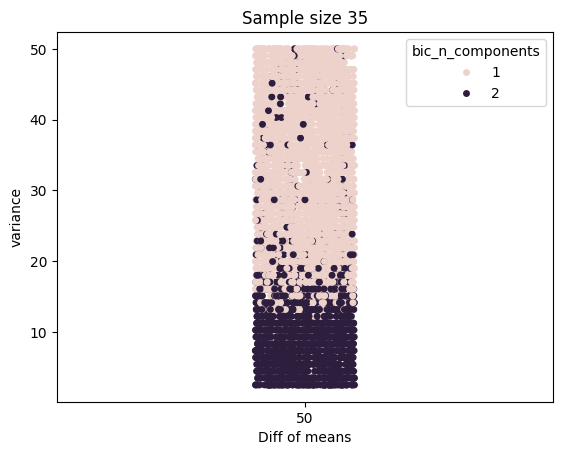

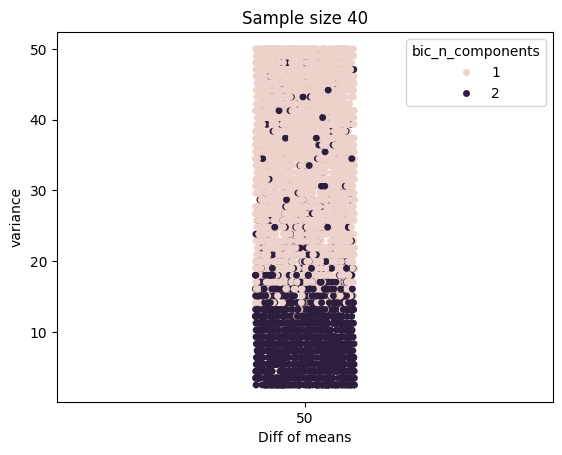

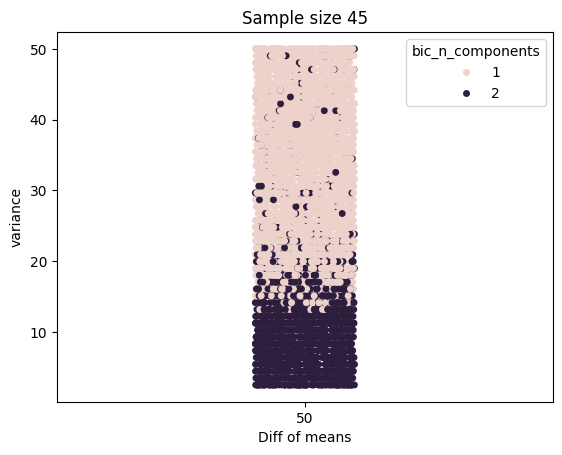

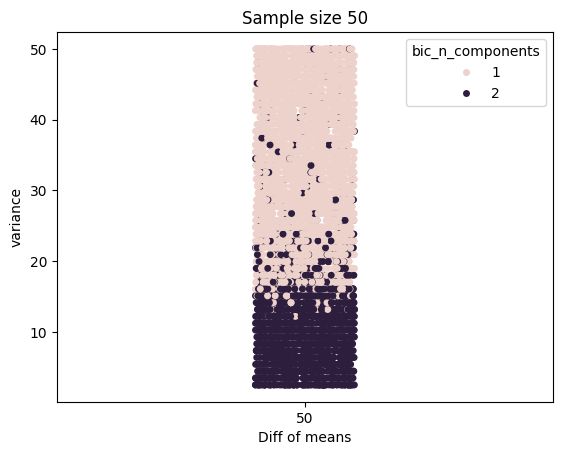

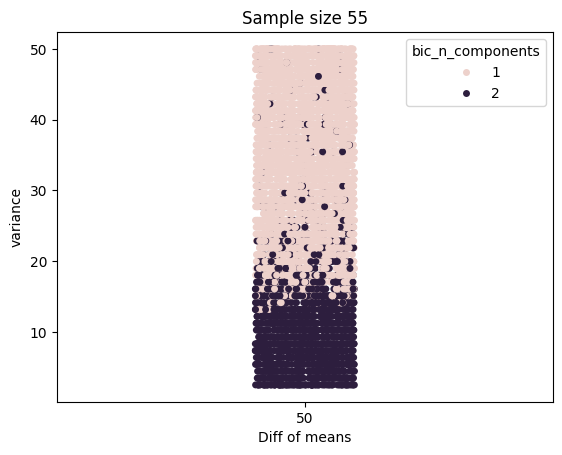

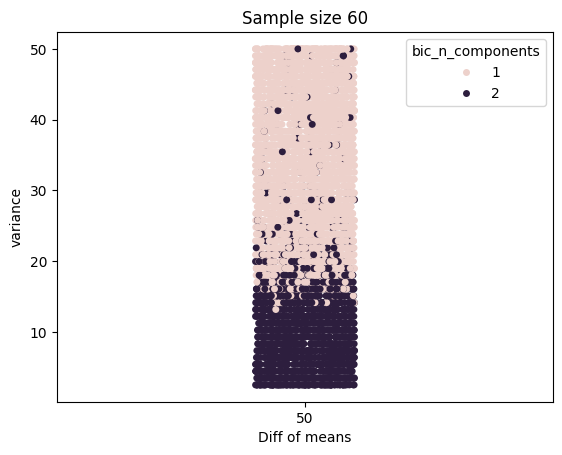

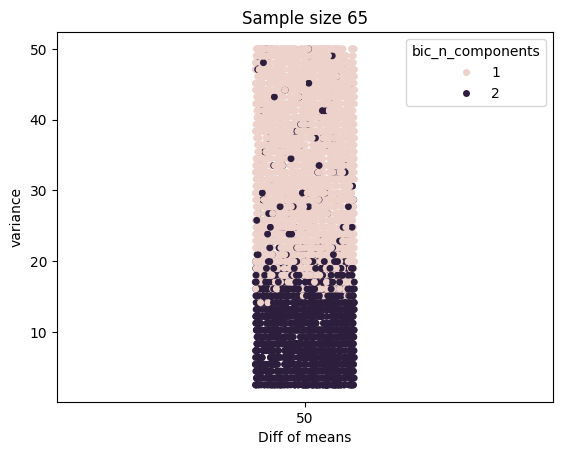

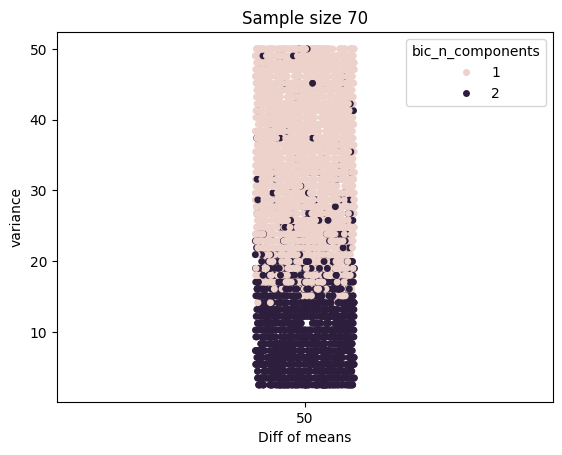

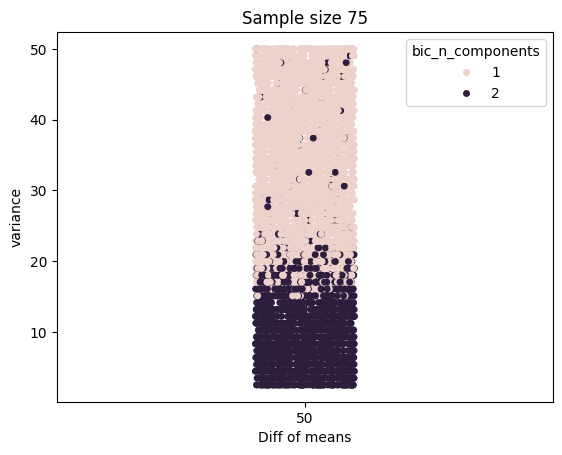

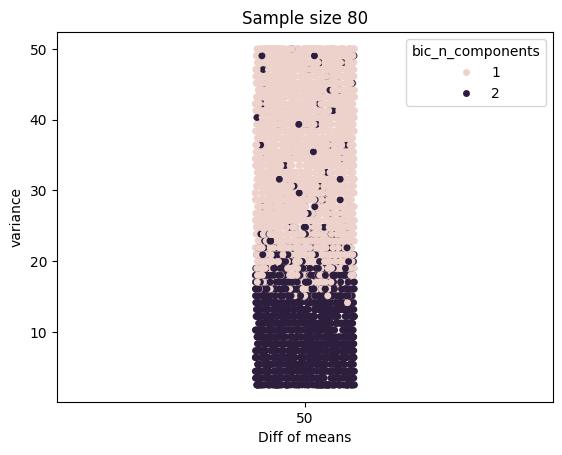

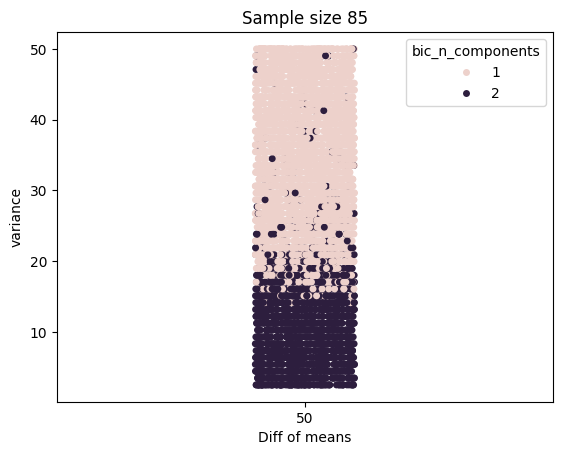

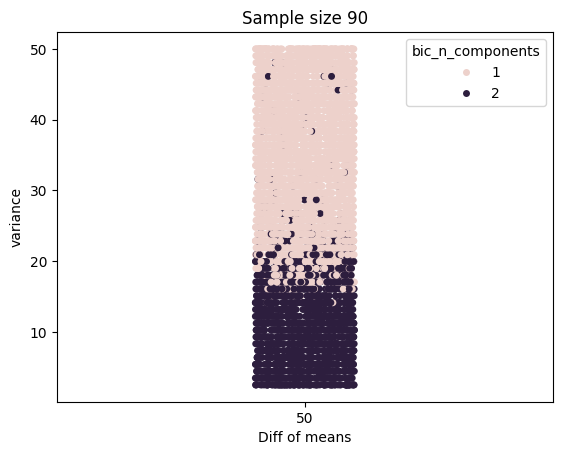

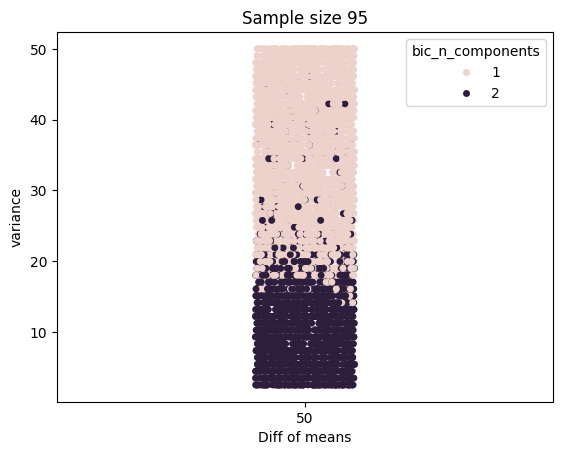

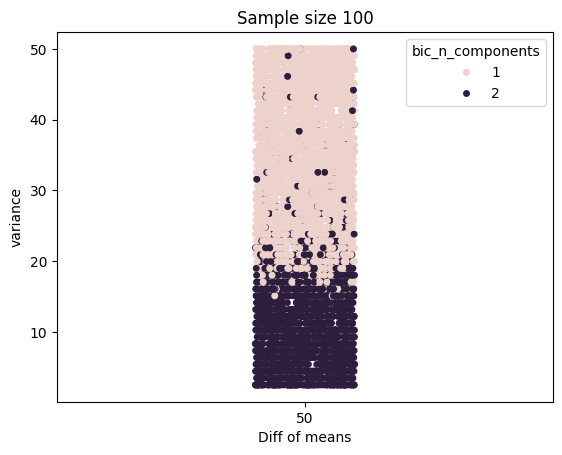

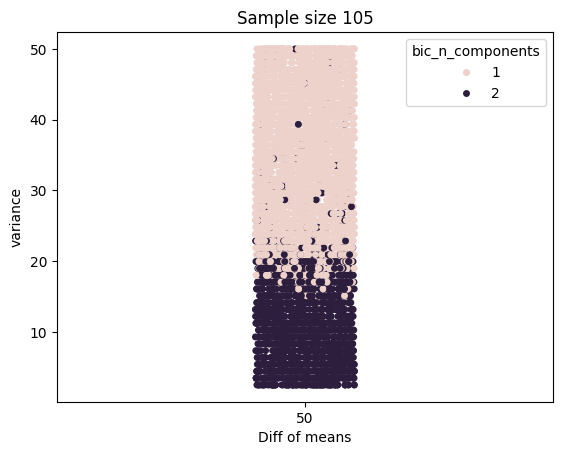

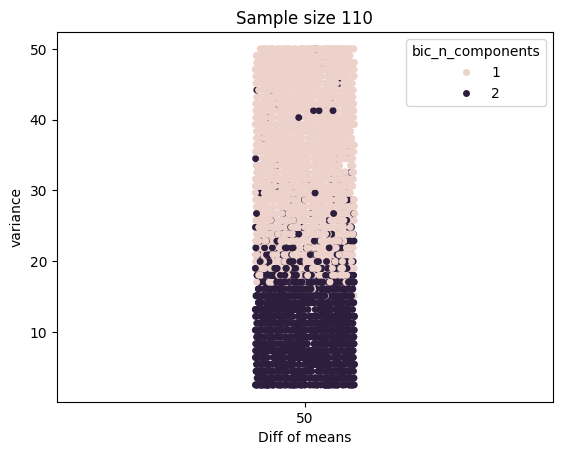

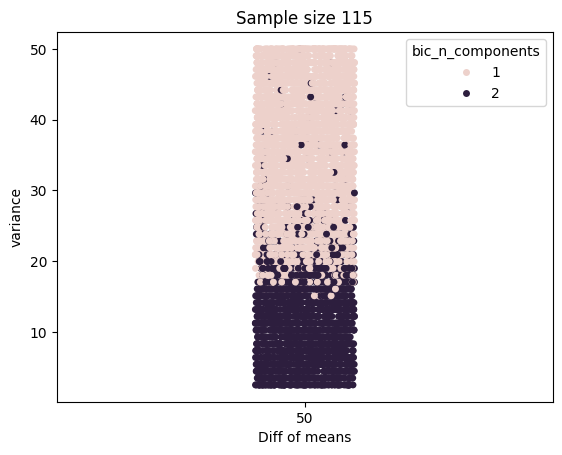

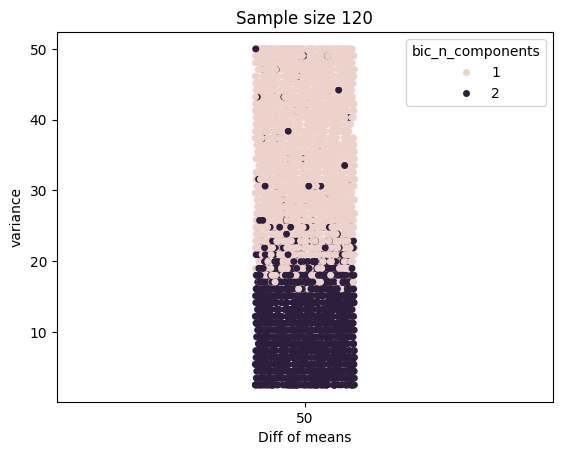

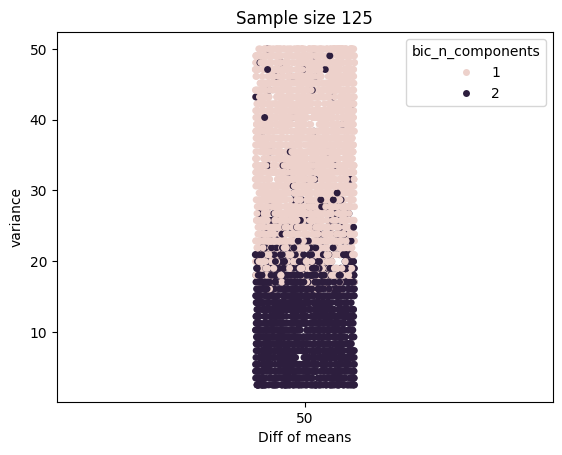

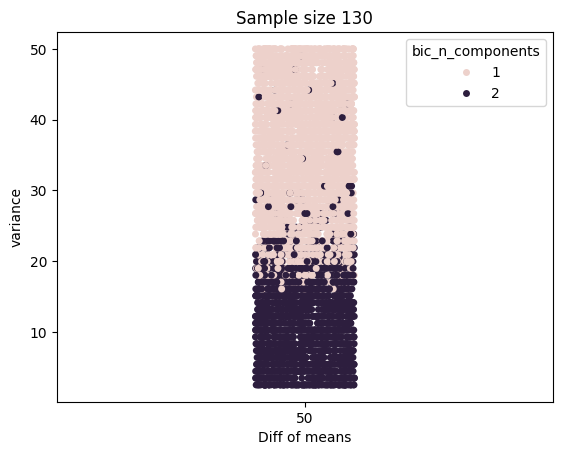

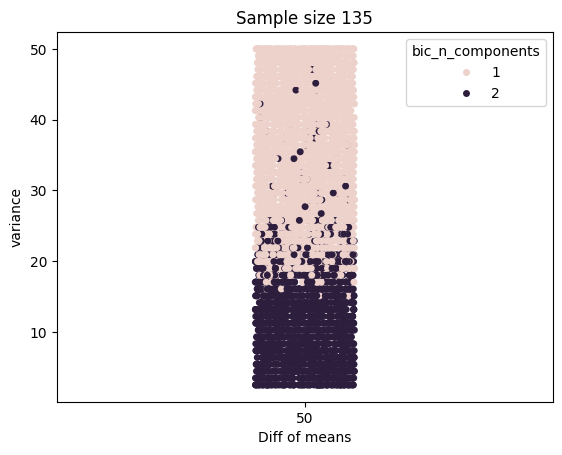

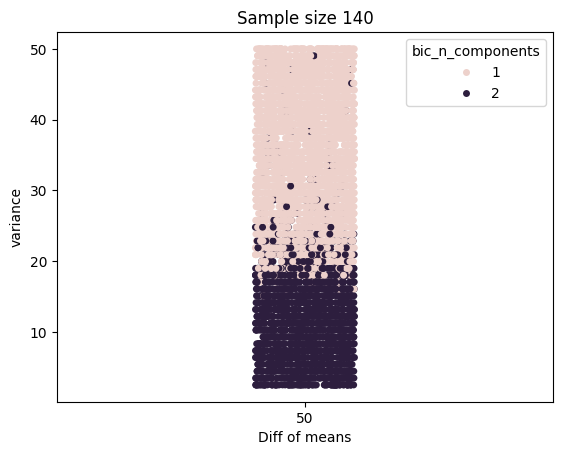

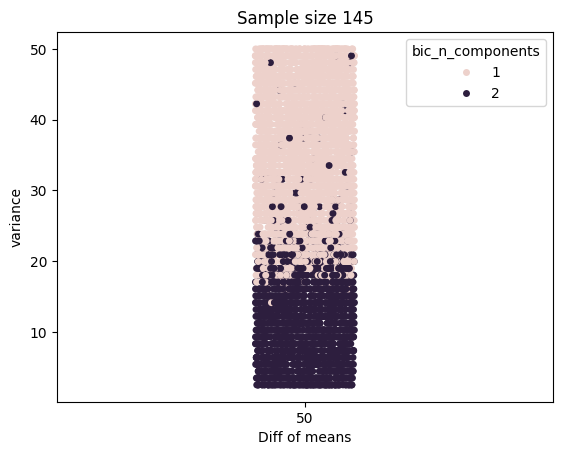

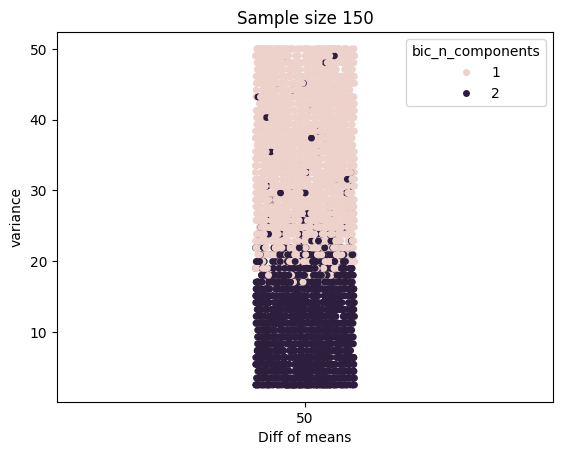

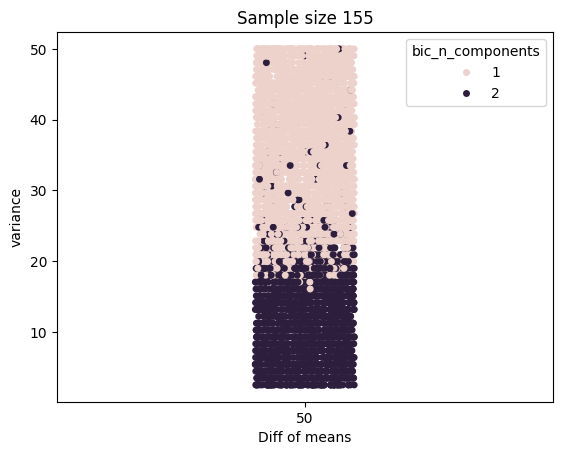

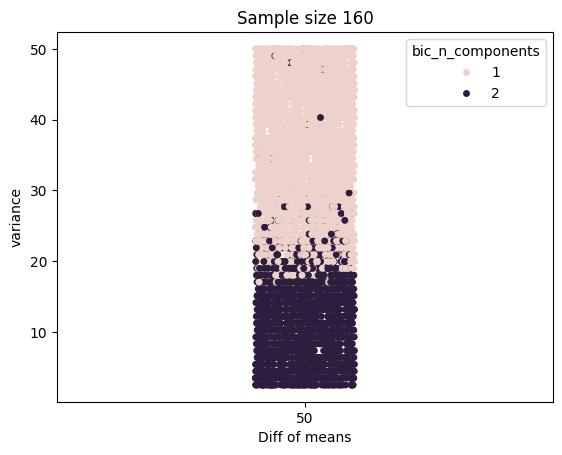

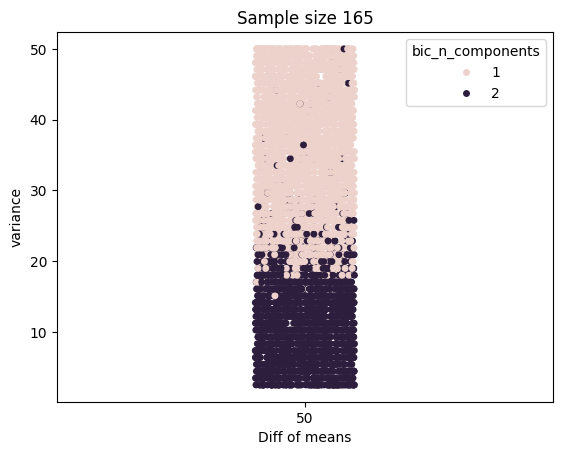

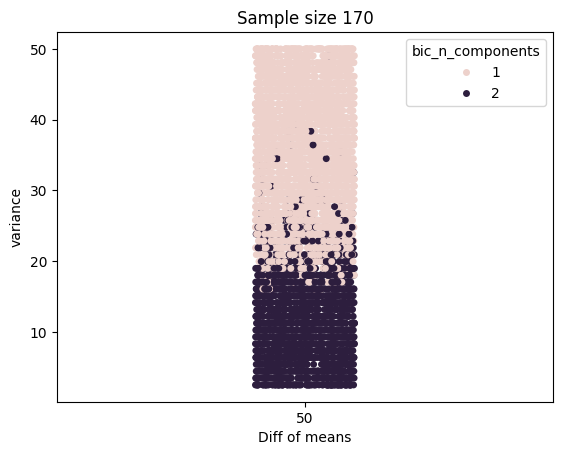

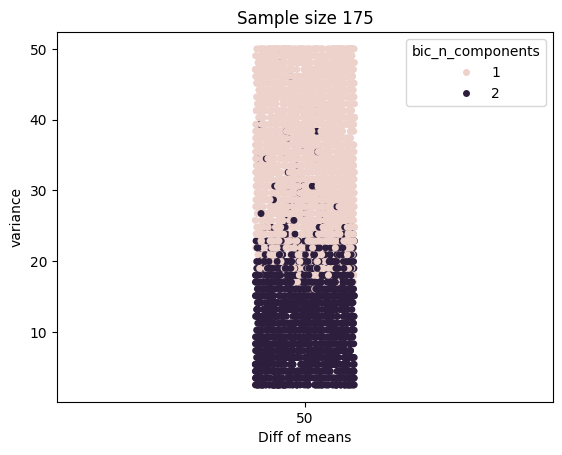

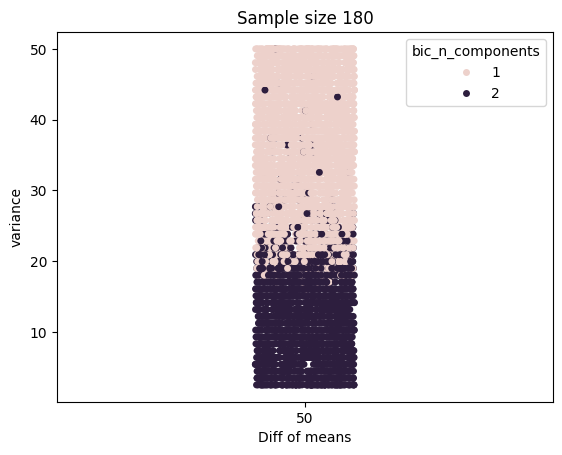

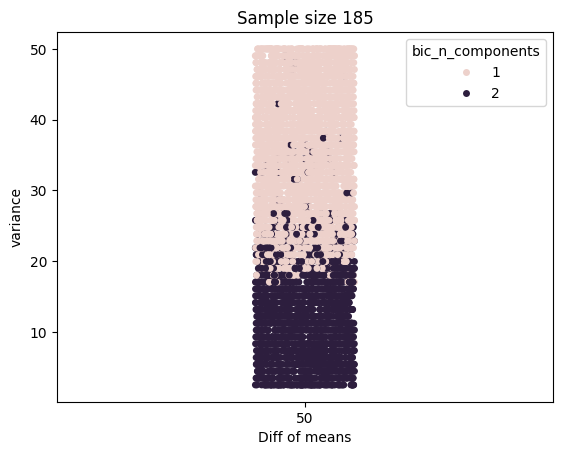

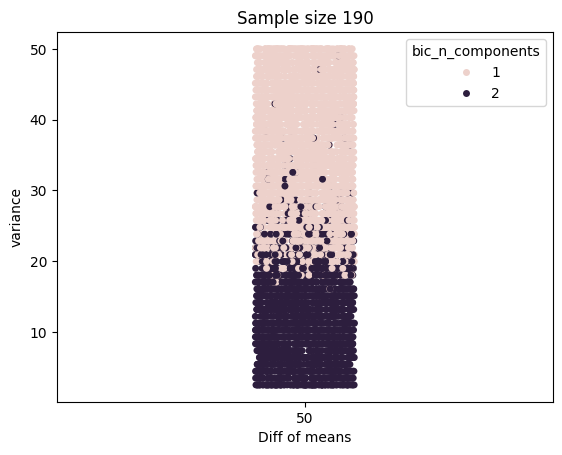

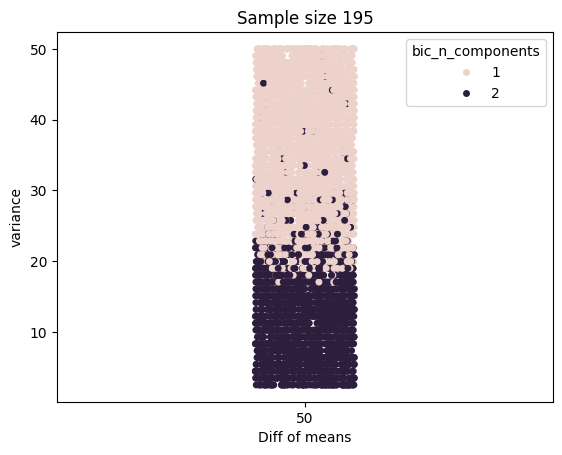

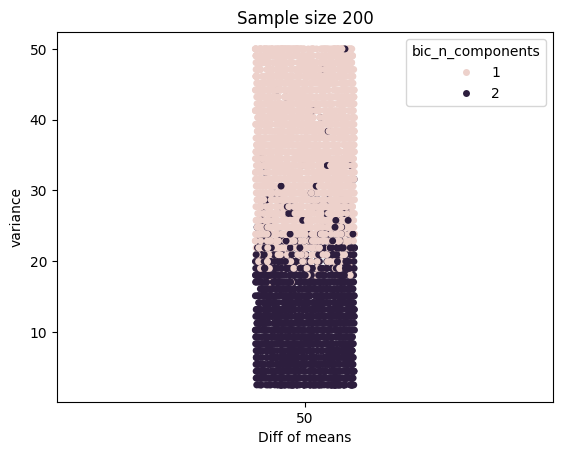

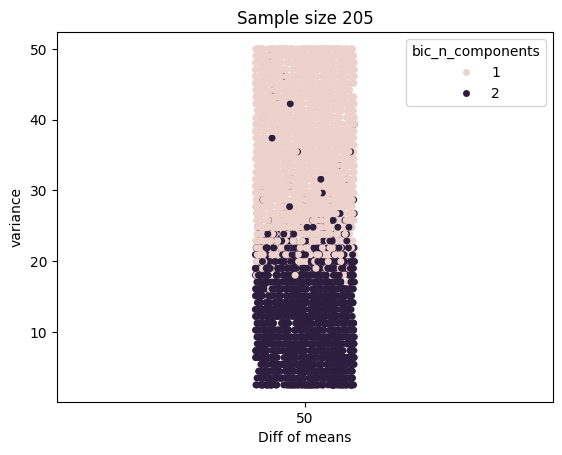

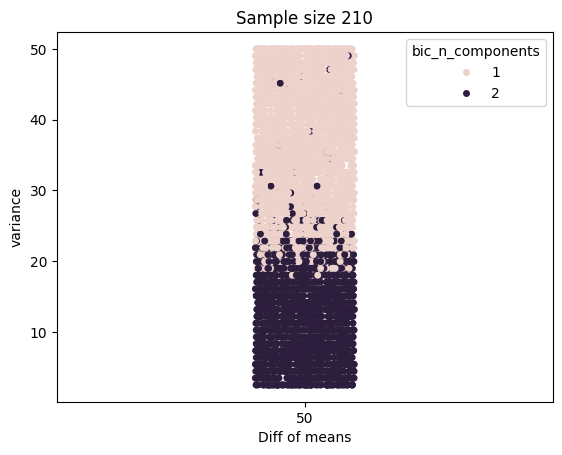

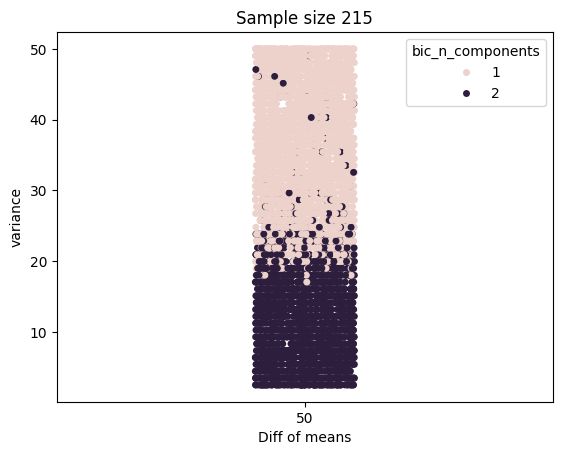

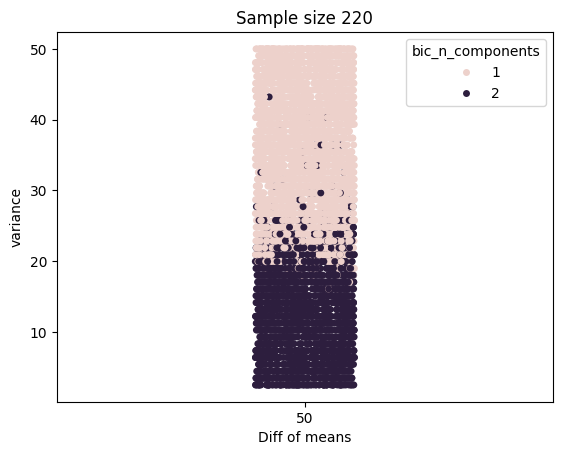

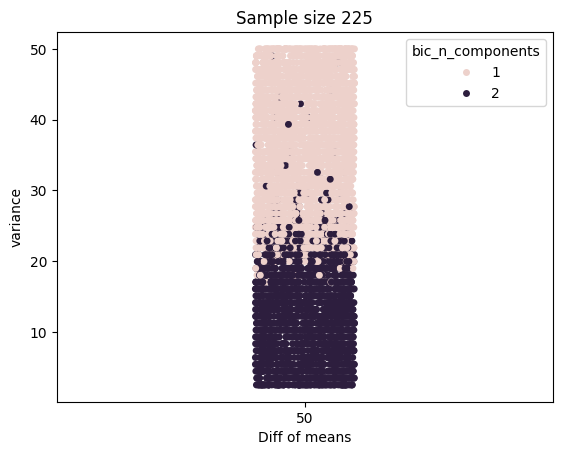

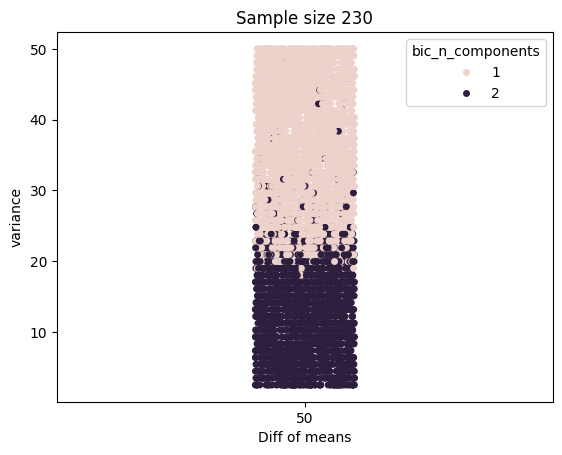

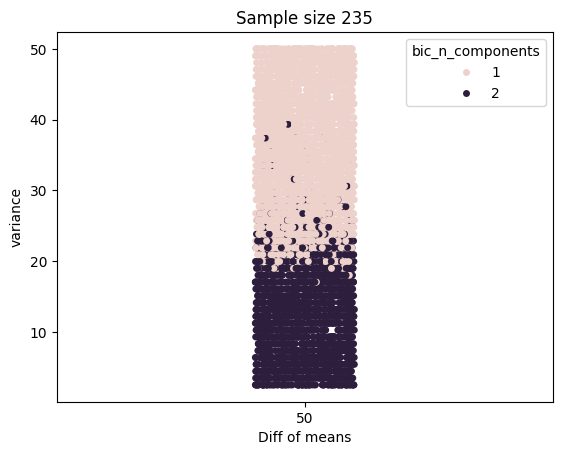

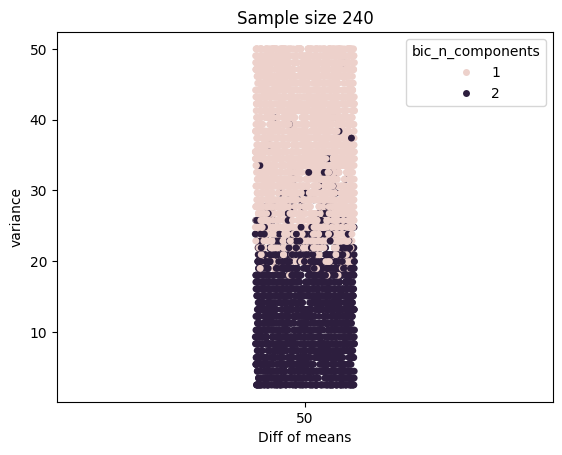

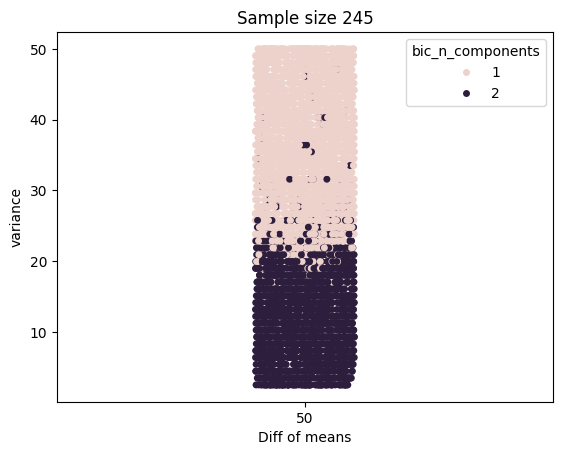

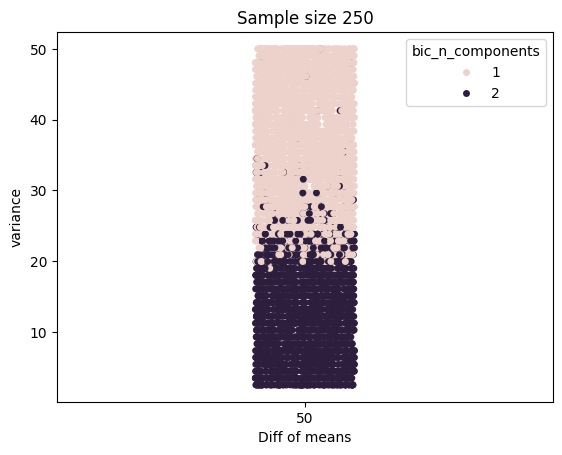

In [58]:
for s in sorted(set(df['sample_size'])):
    sns.stripplot(data=df[df['sample_size']==s], x='seperation', y='stdev', hue='bic_n_components')
    plt.title('Sample size ' + str(s))
    plt.ylabel('variance')
    plt.xlabel('Diff of means')
    plt.show()


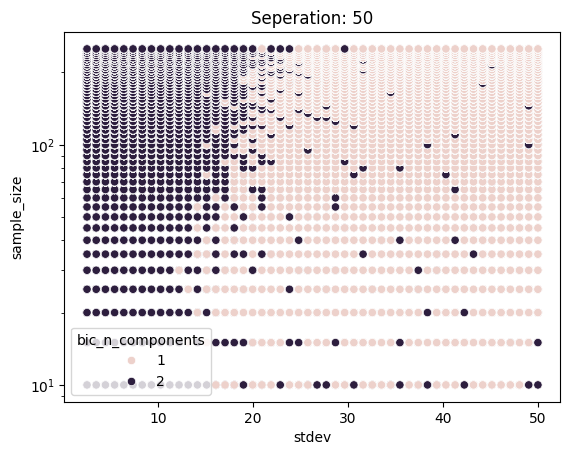

In [59]:
for x in set(df['seperation']):
    sns.scatterplot(data=df[df['seperation']==x], x='stdev', y='sample_size', hue='bic_n_components')
    plt.title(f'Seperation: {x}')
    plt.yscale('log')
    plt.show()

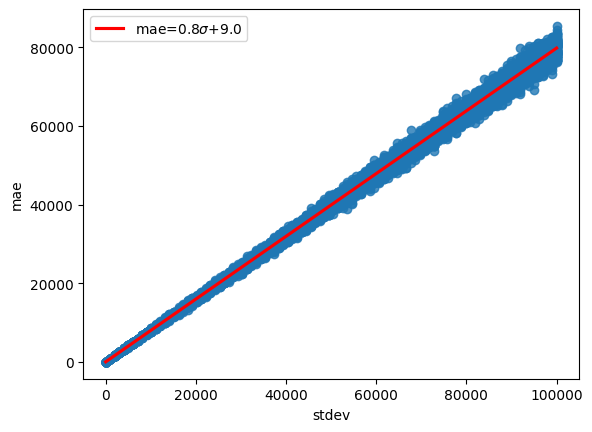

In [102]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import seaborn as sns

from scipy import stats

n_repeats = 100
recs = []
for stdev in np.linspace(1, 100000, 100):
    for _ in range(n_repeats):
        vals = 1000 
        pred_vals = np.random.normal(0, stdev, vals)
        true_vals = np.zeros(vals)
        mae = mean_absolute_error(pred_vals, true_vals)
        recs.append({'stdev': stdev, 'mae': mae})

df6 = pd.DataFrame.from_records(recs)

slope, intercept, r_value, p_value, std_err = stats.linregress(df6['stdev'],df6['mae'])

# use line_kws to set line label for legend
ax = sns.regplot(x="stdev", y="mae", data=df6,  
 line_kws={'color': 'red', 'label':r"mae={0:.1f}$\sigma$+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()
